In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import imageio
import matplotlib
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [2]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [3]:
medium = td.Medium(permittivity=45)
run = True

In [4]:
a=1.5873

In [5]:
lambdas =  a/np.array([0.15,0.48])
lambdas

array([10.582   ,  3.306875])

In [6]:
3e10/(lambdas)  * 1e-9 #frequencies of experiment 

array([2.83500284, 9.07200907])

In [7]:
folder_path=rf"H:\phd stuff\tidy3d\structures\2D SHU"
sample = 1
project_name = fr"20250625 2D eps 45 4-9GHz Different Dipole Position"
empty=False
runtime_ps = 25e-12
min_steps_per_lambda = 25
id0 = ""
ref_slices = []
slab_size_x = 55

chi_0.20_N_10000_posics
chi_0.30_N_10000_posics
chi_0.31_N_10000_posics
chi_0.32_N_10000_posics
chi_0.33_N_10000_posics
chi_0.34_N_10000_posics
chi_0.35_N_10000_posics
chi_0.36_N_10000_posics
chi_0.37_N_10000_posics
Configured successfully.
chi_0.37_N_10000_posics_emmiter_-5.5000 - Sample_0


14:30:44 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

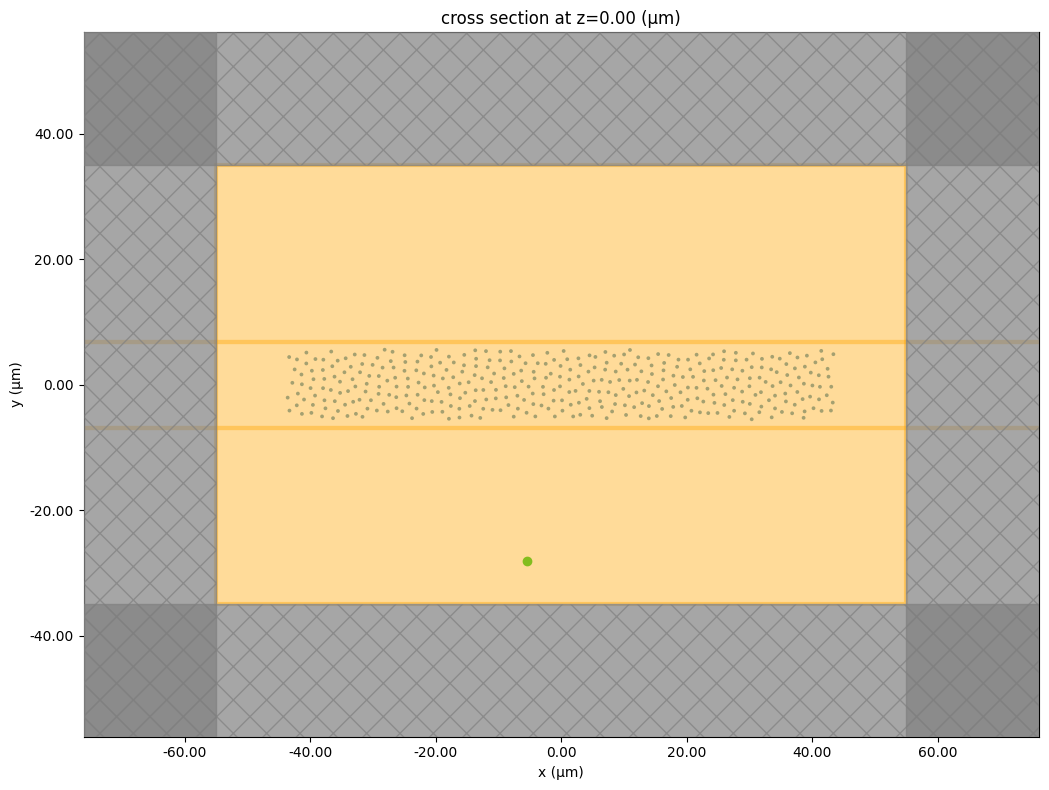

14:30:46 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-5.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=622528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=418620;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\task]8;;\
                                 ]8;id=418620;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\Id]8;;\]8;id=622528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\=]8;;\]8;id=897749;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\fdve]8;;\]8;id=622528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b6edf9c0-2d73-4c09-a571-270cecb9783e\-b6edf9c0-2d73-4c09-a571-270cecb9783e']8;;\.

                                 Task folder: ]8;id=530476;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=530476;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:30:49 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:30:50 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-5.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-985236d8-b091-4f5a-89fd-50395bf6def3' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=462387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=266788;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\task]8;;\
                                 ]8;id=266788;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\Id]8;;\]8;id=462387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\=]8;;\]8;id=350534;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\fdve]8;;\]8;id=462387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-985236d8-b091-4f5a-89fd-50395bf6def3\-985236d8-b091-4f5a-89fd-50395bf6def3']8;;\.

                                 Task folder: ]8;id=218027;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=218027;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:30:52 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

Folder 'H:\phd stuff\tidy3d\data/20250625 2D eps 45 4-9GHz Different Dipole Position/chi_0.37_N_10000_posics/chi_0.37_N_10000_posics_L=4.9/' created successfully.
chi_0.37_N_10000_posics_emmiter_-4.5000 - Sample_0


14:30:53 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

14:30:54 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

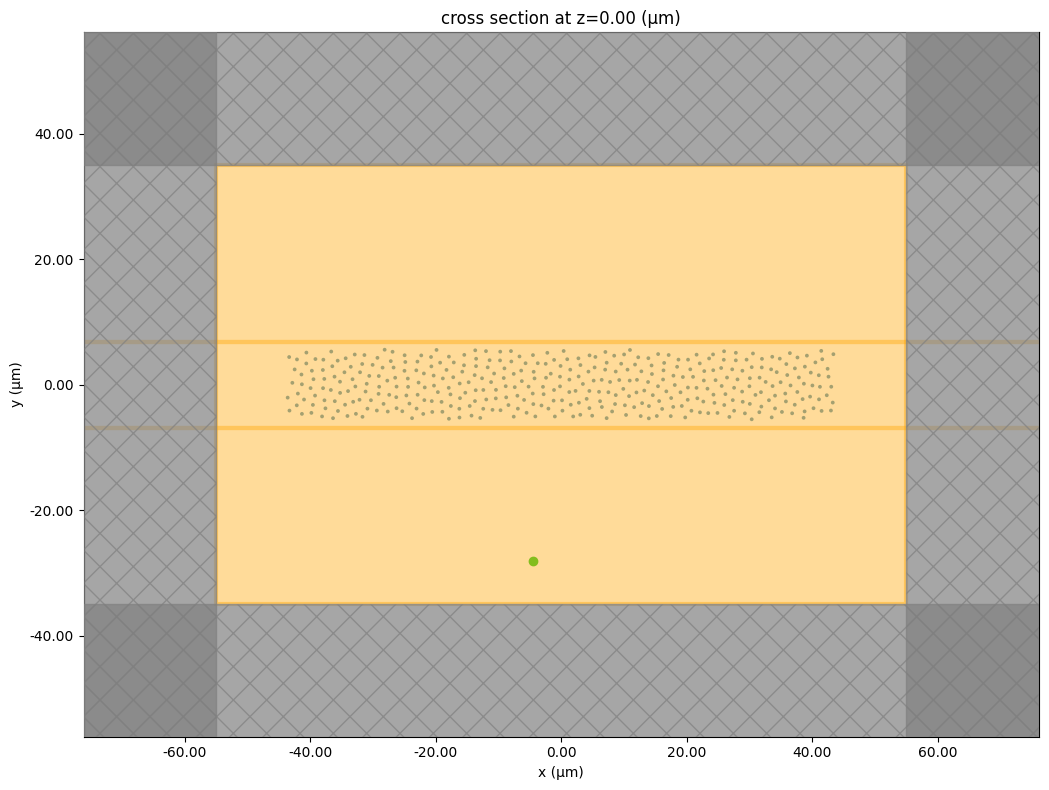

                                 Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-4.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-fe52f7b7-96af-493a-9580-35be5c451fce' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=217595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=436945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\task]8;;\
                                 ]8;id=436945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\Id]8;;\]8;id=217595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\=]8;;\]8;id=504802;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\fdve]8;;\]8;id=217595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fe52f7b7-96af-493a-9580-35be5c451fce\-fe52f7b7-96af-493a-9580-35be5c451fce']8;;\.

                                 Task folder: ]8;id=353056;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=353056;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:30:56 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:30:58 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-4.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=414921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=219819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\task]8;;\
                                 ]8;id=219819;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\Id]8;;\]8;id=414921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\=]8;;\]8;id=328230;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\fdve]8;;\]8;id=414921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4\-f96e326f-6a01-4ce7-abd9-7dffc5dfb2a4']8;;\.

                                 Task folder: ]8;id=872168;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=872168;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:00 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_-3.5000 - Sample_0


14:31:01 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

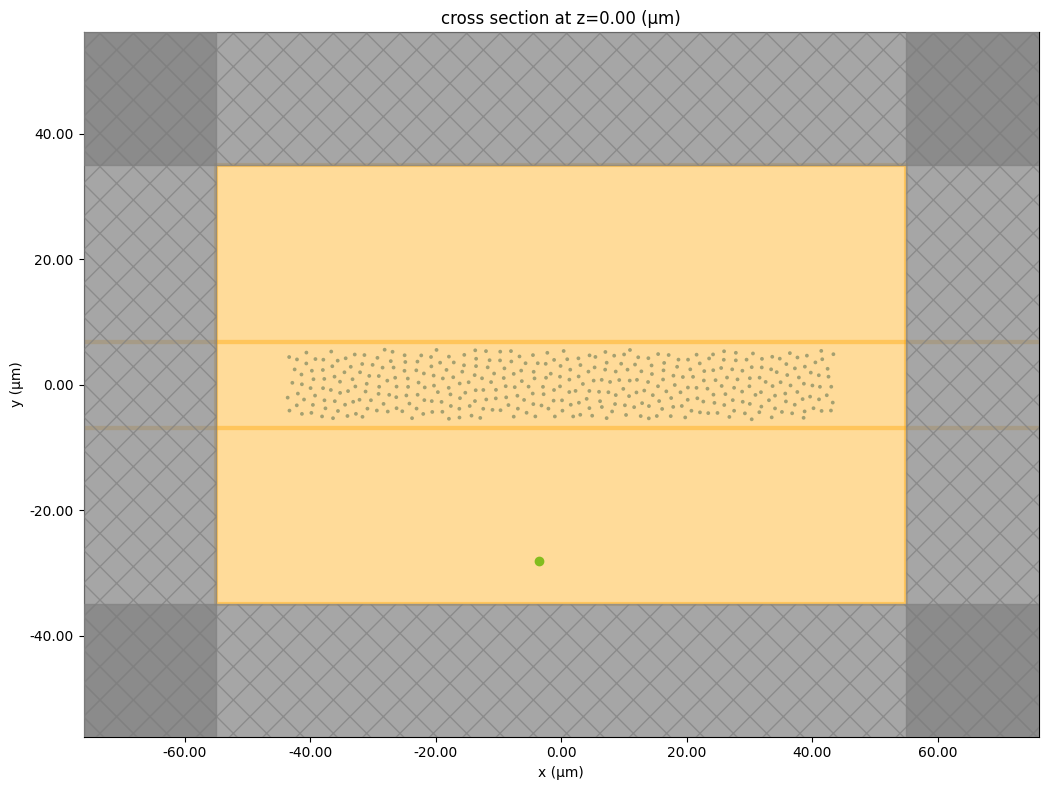

14:31:02 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-3.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=35572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=846991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\task]8;;\
                                 ]8;id=846991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\Id]8;;\]8;id=35572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\=]8;;\]8;id=483698;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\fdve]8;;\]8;id=35572;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74\-b2930d1f-51f0-4a5d-bfff-d21cf91c3b74']8;;\.

                                 Task folder: ]8;id=403993;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=403993;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:04 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:05 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-3.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=183899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=805218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\task]8;;\
                                 ]8;id=805218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\Id]8;;\]8;id=183899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\=]8;;\]8;id=278130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\fdve]8;;\]8;id=183899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-448fbcdc-cd7e-40fd-8c18-058c46a96f64\-448fbcdc-cd7e-40fd-8c18-058c46a96f64']8;;\.

                                 Task folder: ]8;id=901197;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=901197;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:07 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_-2.5000 - Sample_0


14:31:08 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

14:31:09 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

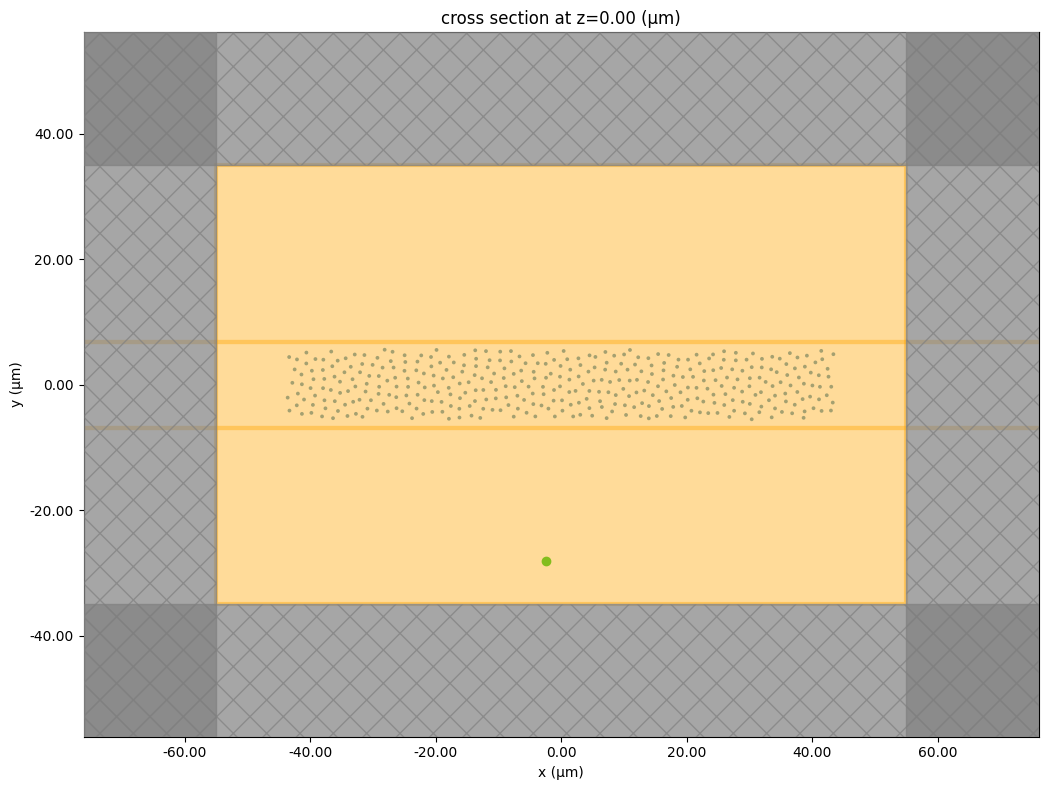

                                 Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-2.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=146609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=277296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\task]8;;\
                                 ]8;id=277296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\Id]8;;\]8;id=146609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\=]8;;\]8;id=139272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\fdve]8;;\]8;id=146609;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ed9a3f3c-ff22-4653-947b-9c28fcbadc65\-ed9a3f3c-ff22-4653-947b-9c28fcbadc65']8;;\.

                                 Task folder: ]8;id=637889;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=637889;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:11 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:13 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-2.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=970299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=779170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\task]8;;\
                                 ]8;id=779170;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\Id]8;;\]8;id=970299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\=]8;;\]8;id=58494;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\fdve]8;;\]8;id=970299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d984daea-a13f-4c9e-aea2-def6b6c9c8ac\-d984daea-a13f-4c9e-aea2-def6b6c9c8ac']8;;\.

                                 Task folder: ]8;id=381093;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=381093;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:15 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_-1.5000 - Sample_0


14:31:16 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

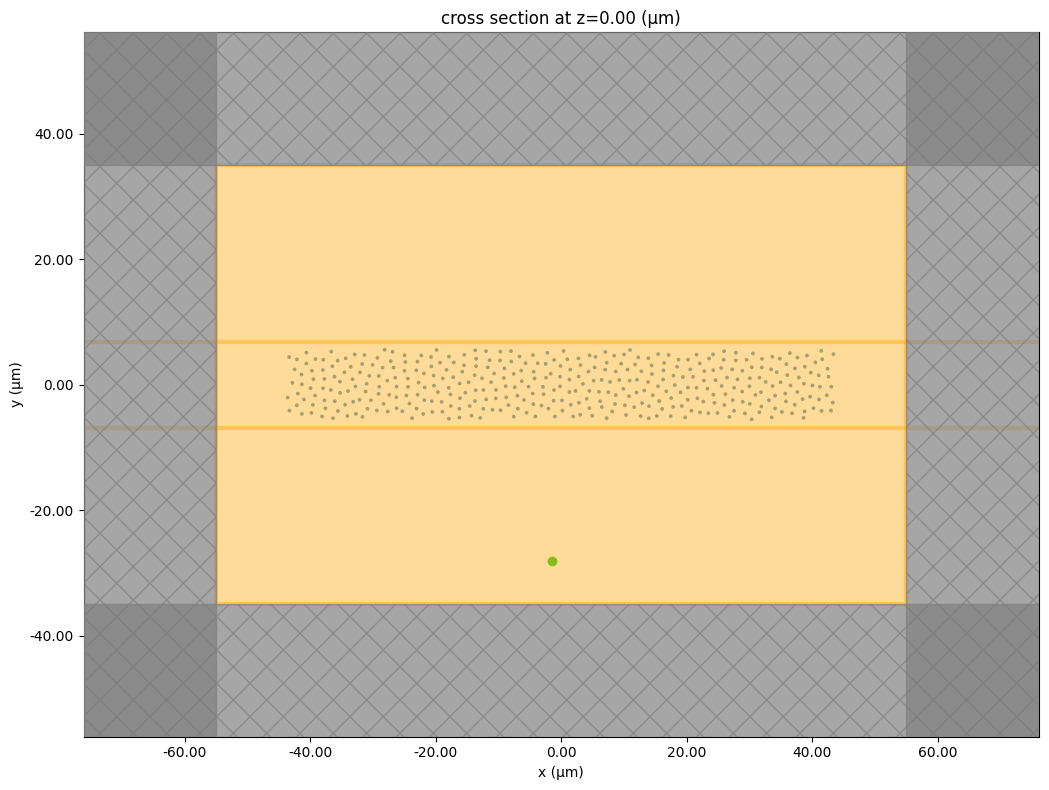

14:31:17 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-1.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-fa96303d-b429-494e-990e-f3843e067ade' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=147719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=527975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\task]8;;\
                                 ]8;id=527975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\Id]8;;\]8;id=147719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\=]8;;\]8;id=671999;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\fdve]8;;\]8;id=147719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa96303d-b429-494e-990e-f3843e067ade\-fa96303d-b429-494e-990e-f3843e067ade']8;;\.

                                 Task folder: ]8;id=921441;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=921441;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:19 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:20 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-1.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=626012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=635433;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\task]8;;\
                                 ]8;id=635433;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\Id]8;;\]8;id=626012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\=]8;;\]8;id=379750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\fdve]8;;\]8;id=626012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-659ffbe1-a493-4d30-8034-0c3b53c5913f\-659ffbe1-a493-4d30-8034-0c3b53c5913f']8;;\.

                                 Task folder: ]8;id=120123;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=120123;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:22 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_-0.5000 - Sample_0


14:31:23 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

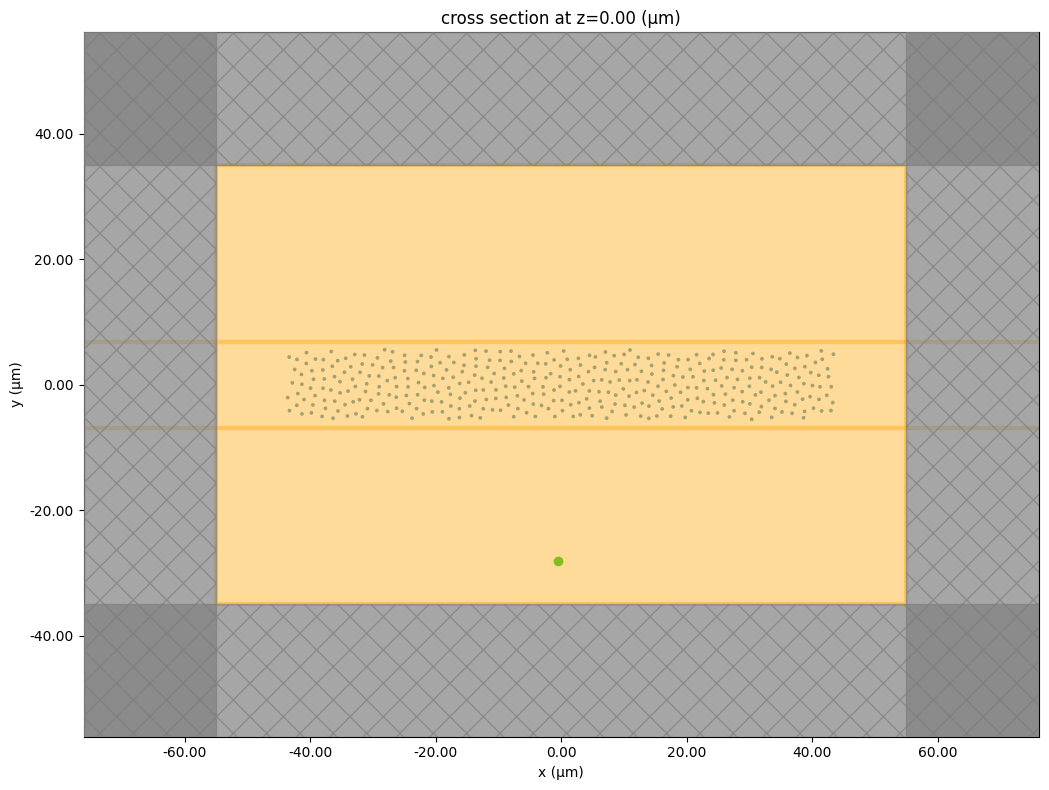

14:31:24 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-0.5000 -     
                                 Sample_0_ref' with task_id                     
                                 'fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=120072;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=538258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\task]8;;\
                                 ]8;id=538258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\Id]8;;\]8;id=120072;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\=]8;;\]8;id=163666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\fdve]8;;\]8;id=120072;https://tidy3d.simulation.cloud/workbench?taskId=fdve-36953585-99d7-4e85-b39c-5ef2feef3bfa\-36953585-99d7-4e85-b39c-5ef2feef3bfa']8;;\.

                                 Task folder: ]8;id=241229;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=241229;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:26 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:27 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_-0.5000 -     
                                 Sample_0' with task_id                         
                                 'fdve-6d60dbb7-4801-425b-af29-808bd75b5403' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=64282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=431763;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\task]8;;\
                                 ]8;id=431763;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\Id]8;;\]8;id=64282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\=]8;;\]8;id=940617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\fdve]8;;\]8;id=64282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6d60dbb7-4801-425b-af29-808bd75b5403\-6d60dbb7-4801-425b-af29-808bd75b5403']8;;\.

                                 Task folder: ]8;id=580885;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=580885;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:30 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_0.5000 - Sample_0


14:31:31 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

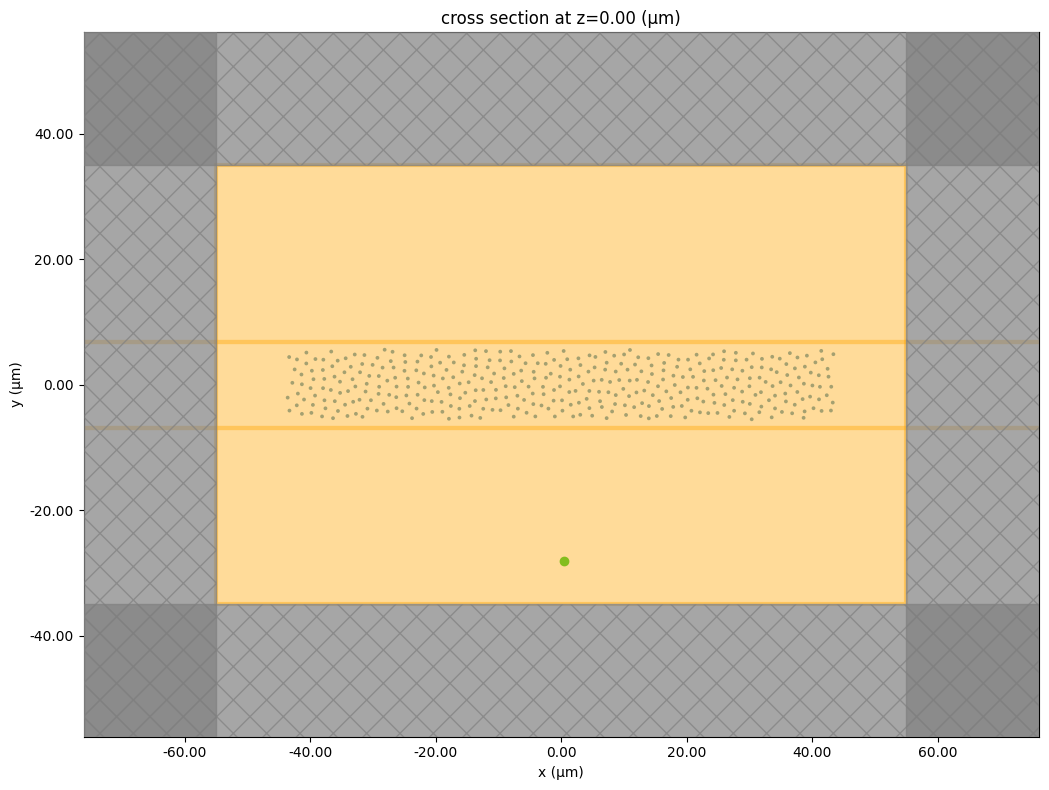

                                 Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_0.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=38410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=374628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\task]8;;\
                                 ]8;id=374628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\Id]8;;\]8;id=38410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\=]8;;\]8;id=68587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\fdve]8;;\]8;id=38410;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d9bdd315-3576-4a99-bf9c-2b9b76744490\-d9bdd315-3576-4a99-bf9c-2b9b76744490']8;;\.

                                 Task folder: ]8;id=476664;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=476664;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:34 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:35 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_0.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=73275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=108371;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\task]8;;\
                                 ]8;id=108371;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\Id]8;;\]8;id=73275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\=]8;;\]8;id=215110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\fdve]8;;\]8;id=73275;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5f6fdda4-8018-40a2-90b6-165acc95ab39\-5f6fdda4-8018-40a2-90b6-165acc95ab39']8;;\.

                                 Task folder: ]8;id=470024;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=470024;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:37 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_1.5000 - Sample_0


14:31:38 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

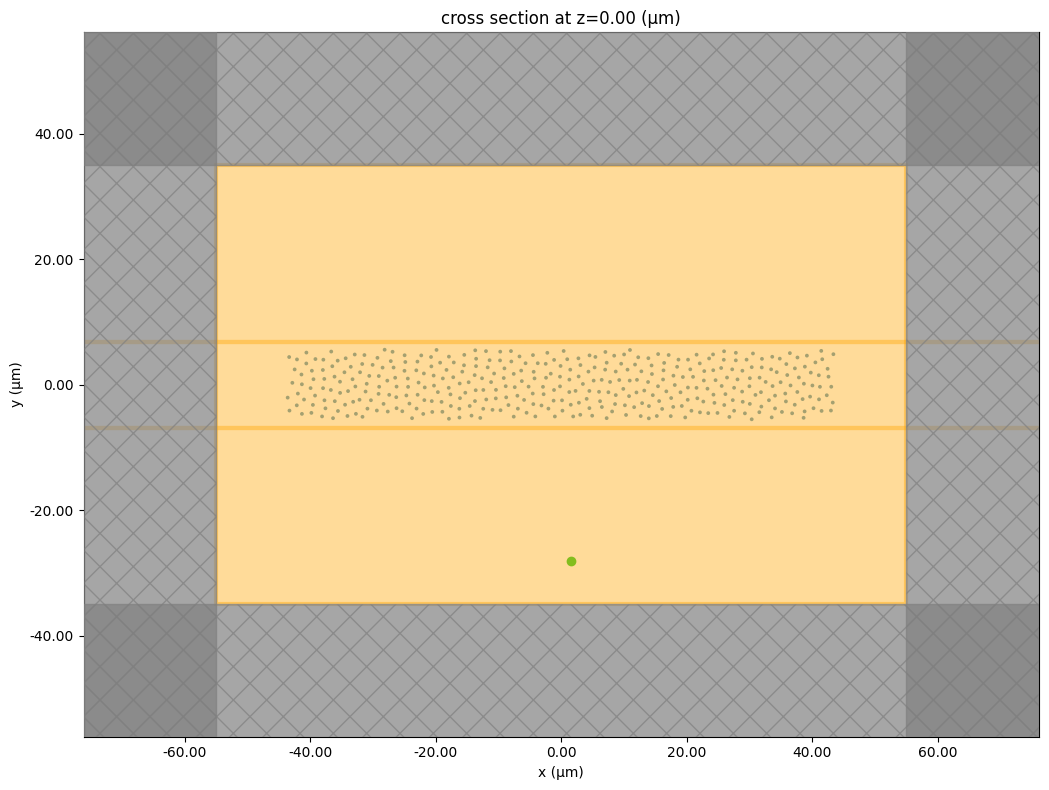

14:31:39 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_1.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-8546845f-eef0-4bc5-8594-406547bdeed0' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=545742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=866519;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\task]8;;\
                                 ]8;id=866519;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\Id]8;;\]8;id=545742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\=]8;;\]8;id=281655;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\fdve]8;;\]8;id=545742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8546845f-eef0-4bc5-8594-406547bdeed0\-8546845f-eef0-4bc5-8594-406547bdeed0']8;;\.

                                 Task folder: ]8;id=607489;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=607489;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:41 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:42 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_1.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=613364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=244607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\task]8;;\
                                 ]8;id=244607;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\Id]8;;\]8;id=613364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\=]8;;\]8;id=957356;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\fdve]8;;\]8;id=613364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea20791f-9522-44fc-93e2-66d0da7e6df1\-ea20791f-9522-44fc-93e2-66d0da7e6df1']8;;\.

                                 Task folder: ]8;id=224232;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=224232;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:44 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_2.5000 - Sample_0


14:31:45 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

14:31:46 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

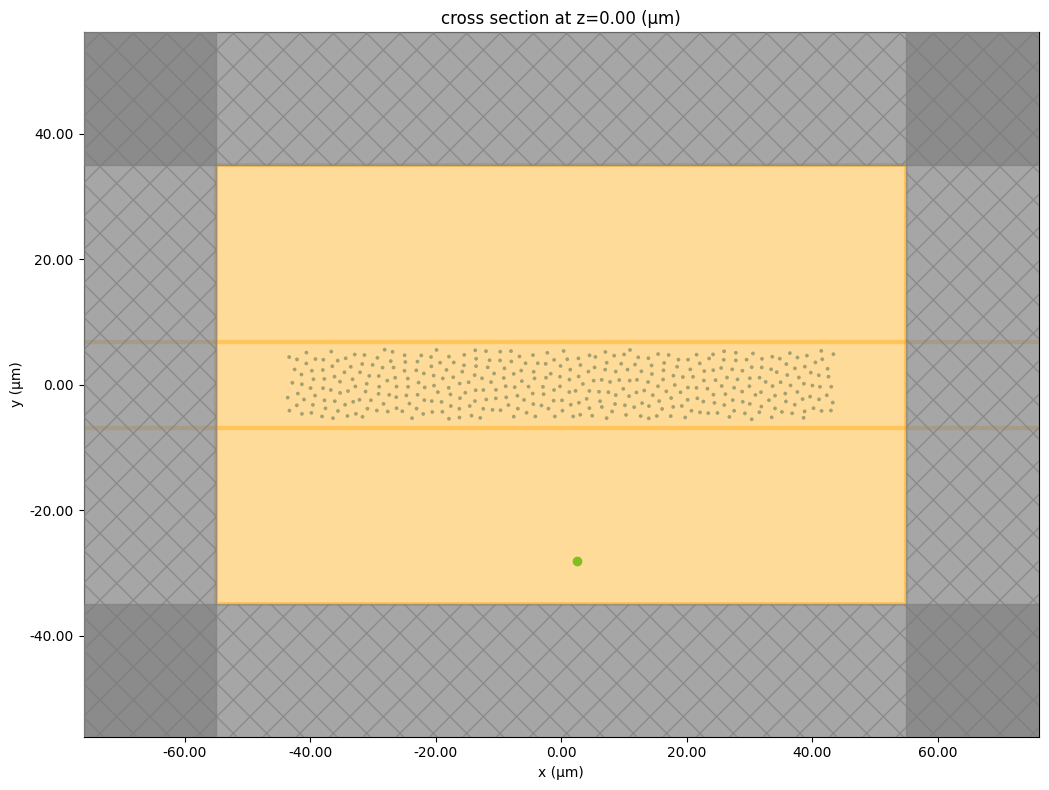

                                 Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_2.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-c70f50a0-19dd-46e2-8466-c57794a2977b' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=674700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=305497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\task]8;;\
                                 ]8;id=305497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\Id]8;;\]8;id=674700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\=]8;;\]8;id=367541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\fdve]8;;\]8;id=674700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c70f50a0-19dd-46e2-8466-c57794a2977b\-c70f50a0-19dd-46e2-8466-c57794a2977b']8;;\.

                                 Task folder: ]8;id=653267;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=653267;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:48 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:49 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_2.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-8f812f09-80df-42a2-876e-90f715aa9eb5' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=723220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=766531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\task]8;;\
                                 ]8;id=766531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\Id]8;;\]8;id=723220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\=]8;;\]8;id=456135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\fdve]8;;\]8;id=723220;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8f812f09-80df-42a2-876e-90f715aa9eb5\-8f812f09-80df-42a2-876e-90f715aa9eb5']8;;\.

                                 Task folder: ]8;id=763728;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=763728;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:52 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_3.5000 - Sample_0


14:31:53 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

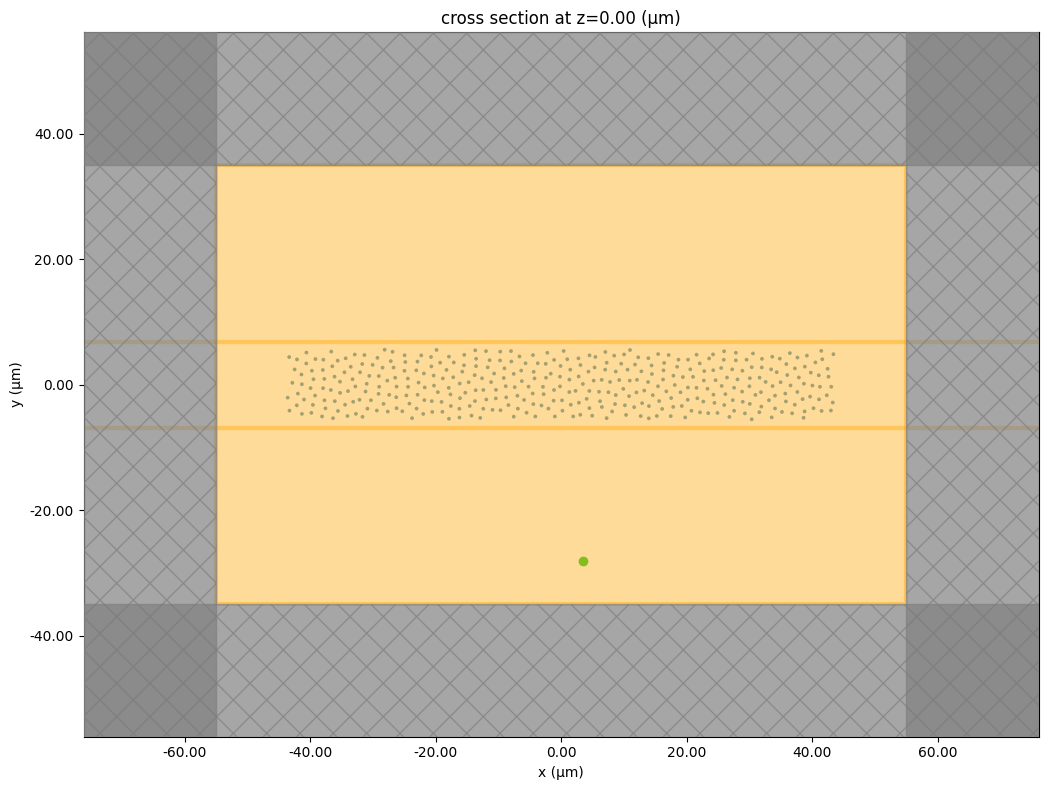

14:31:54 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_3.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=607193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=714369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\task]8;;\
                                 ]8;id=714369;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\Id]8;;\]8;id=607193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\=]8;;\]8;id=846582;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\fdve]8;;\]8;id=607193;https://tidy3d.simulation.cloud/workbench?taskId=fdve-adc3fb9a-6d26-4c2d-8e70-227d419a14b3\-adc3fb9a-6d26-4c2d-8e70-227d419a14b3']8;;\.

                                 Task folder: ]8;id=253806;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=253806;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:56 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:31:57 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_3.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=22641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=329839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\task]8;;\
                                 ]8;id=329839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\Id]8;;\]8;id=22641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\=]8;;\]8;id=884322;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\fdve]8;;\]8;id=22641;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c\-d88509b5-5e6f-41f6-a0dd-ec1f3096d70c']8;;\.

                                 Task folder: ]8;id=537247;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=537247;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:31:59 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_4.5000 - Sample_0


14:32:00 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

14:32:01 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

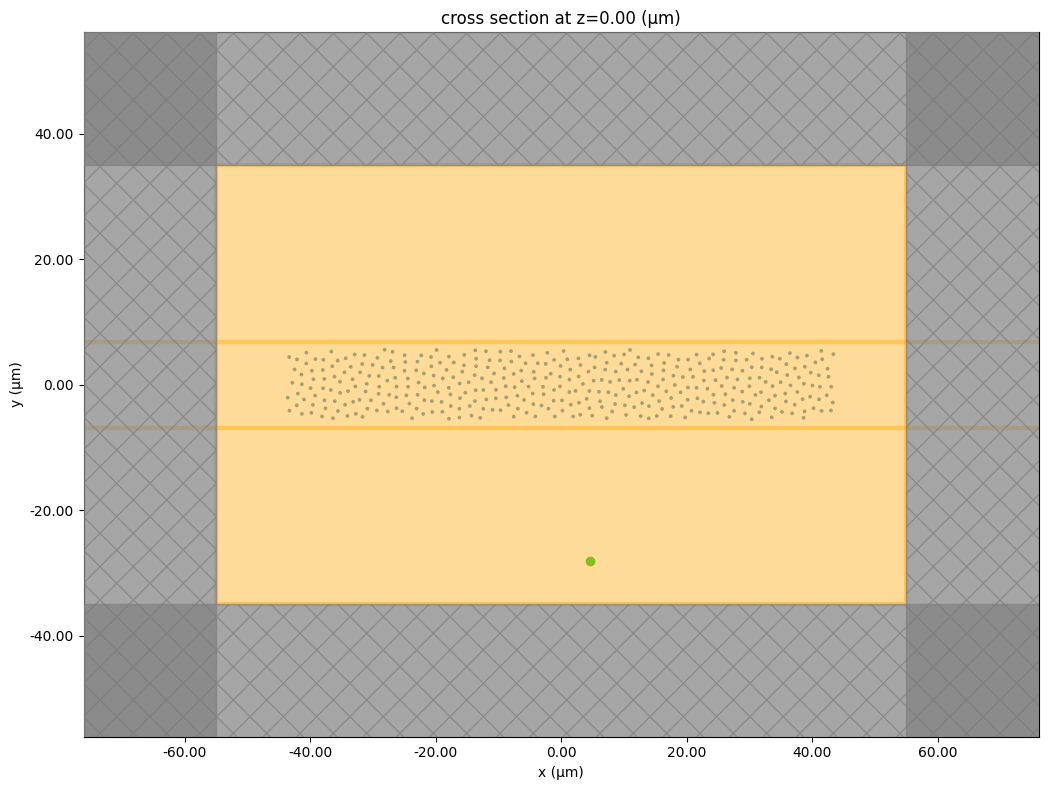

                                 Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_4.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=552377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=363219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\task]8;;\
                                 ]8;id=363219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\Id]8;;\]8;id=552377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\=]8;;\]8;id=70699;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\fdve]8;;\]8;id=552377;https://tidy3d.simulation.cloud/workbench?taskId=fdve-020031d8-9c80-4662-a77a-eb6c81cde4c0\-020031d8-9c80-4662-a77a-eb6c81cde4c0']8;;\.

                                 Task folder: ]8;id=656410;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=656410;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:32:03 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:32:04 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_4.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=954626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=772495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\task]8;;\
                                 ]8;id=772495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\Id]8;;\]8;id=954626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\=]8;;\]8;id=101436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\fdve]8;;\]8;id=954626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a34cd08-5fb6-4378-8a6b-293e0f53c83d\-0a34cd08-5fb6-4378-8a6b-293e0f53c83d']8;;\.

                                 Task folder: ]8;id=134863;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=134863;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:32:07 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.37_N_10000_posics_emmiter_5.5000 - Sample_0


14:32:08 W. Europe Daylight Time WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

                                 WARNING: The grid step in x has a value of     
                                 0.1323 (um), which was detected as being large 
                                 when compared to the central wavelength of     
                                 sources[0] within the medium associated with   
                                 structures[0], given by 0.7512 (um). To avoid  
                                 inaccuracies, it is recommended the grid size  
                                 is reduced.                                    

                                 WARNING: Suppressed 2 WARNING messages.        

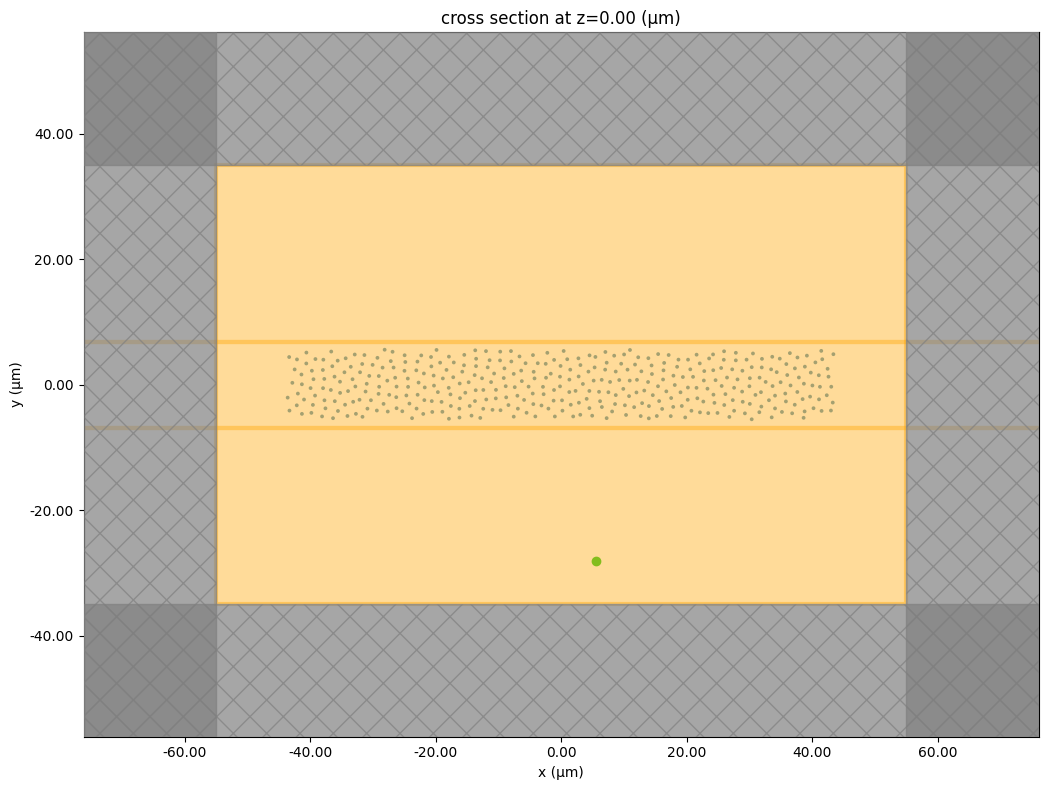

14:32:09 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_5.5000 -      
                                 Sample_0_ref' with task_id                     
                                 'fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=56130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=230350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\task]8;;\
                                 ]8;id=230350;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\Id]8;;\]8;id=56130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\=]8;;\]8;id=472859;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\fdve]8;;\]8;id=56130;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4\-d7ac25a3-0d44-4672-aa90-04ac1d22bcf4']8;;\.

                                 Task folder: ]8;id=224053;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=224053;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:32:11 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

14:32:12 W. Europe Daylight Time Created task                                   
                                 'chi_0.37_N_10000_posics_emmiter_5.5000 -      
                                 Sample_0' with task_id                         
                                 'fdve-0179b2c2-a688-400e-82da-c48de2f76f97' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=483596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=750805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\task]8;;\
                                 ]8;id=750805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\Id]8;;\]8;id=483596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\=]8;;\]8;id=411057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\fdve]8;;\]8;id=483596;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0179b2c2-a688-400e-82da-c48de2f76f97\-0179b2c2-a688-400e-82da-c48de2f76f97']8;;\.

                                 Task folder: ]8;id=12775;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\'20250625 2D eps 45 4-9GHz ]8;;\       
                                 ]8;id=12775;https://tidy3d.simulation.cloud/folders/folder-6f701da4-e398-497b-95f4-6b963c8e8664\Different Dipole Position']8;;\.

Output()

14:32:14 W. Europe Daylight Time Maximum FlexCredit cost: 0.780. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

chi_0.38_N_10000_posics
chi_0.39_N_10000_posics
chi_0.40_N_10000_posics


In [8]:
count = 0
for l,file in enumerate(natsorted(os.listdir(folder_path))):
    print(Path(file).stem)
    if Path(file).stem not in ["chi_0.37_N_10000_posics"]:
        continue
    data = []
    centers = []

    with open(os.path.join(folder_path, file),"r") as f: 
        lines = f.read().splitlines() 
        i=0
        index = 1
        num_samples = int(lines[index].split()[0])

        while num_samples>0 and i < sample+1:
            try:
                num_samples = int(lines[index].split()[0])
                info = lines[index]
                old_index = index
                index += num_samples+1
                li = (lines[old_index+1:index])
                centers = np.array([list(map(float, item.split())) for item in li])
                data += [{
                    "centers":centers,
                    "Lx":float(lines[old_index].split()[1]),
                    "Ly":float(lines[old_index].split()[2]),
                    "points":float(lines[old_index].split()[0]),
                }]
                i+=1
            except:
                num_samples = 0
    

    for k,item in enumerate(data):
        if k >= sample:
            continue
        

        structure_1 = AM.loadAndRunStructure(key = tidy3dAPI
                    ,direction="z", lambda_range=lambdas,
                    box_size= data[k]['Lx'],runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                   scaling=1,shuoff_condtion=1e-20, verbose=True,
                   monitors=["flux"],
                   freqs=500, 
                   source="planewave", 
                   width=0.4, ref_only=True
                   )


        sim = structure_1.sim



        boundaries= td.BoundarySpec(
                x=td.Boundary(plus=td.Absorber(num_layers=160),minus=td.Absorber(num_layers=160)),
                y=td.Boundary(plus=td.Absorber(num_layers=160),minus=td.Absorber(num_layers=160)),
                z=td.Boundary.periodic(),
            )
        sim = sim.copy(update={'boundary_spec':boundaries})
        sim = sim.copy(update={'sources':[]})
        sim = sim.copy(update={'monitors':[]})


        slices= [0.07]
        for l,slicing in enumerate(slices):
         x_positions =  np.arange(-5.5, 6.5, 1)
         for n,x_position in enumerate(x_positions):
            run_name = f"{Path(file).stem}_emmiter_{x_position:.4f} - Sample_{k}"
            print(run_name)
            count = count+1
            Lx,Ly=110,70
            sim = sim.copy(update={'size':[Lx,Ly,0]})


            sources = []
            y_position = -100/2*a*slicing-22.5
            
            sources.append(
                    td.PointDipole(
                        center=(x_position, y_position, 0), 
                        source_time=td.GaussianPulse(freq0=structure_1.freq0, fwidth=structure_1.freqw),
                        polarization='Ez'
                    )
                )


            sim = sim.copy(update={'sources':sources})
            

            

            time_monitorFieldOut = td.FieldTimeMonitor(
                        center = (0,0,0),
                        size = (Lx,Ly,0),
                            start=0,
                            stop=structure_1.t_stop,
                            interval=50,
                            fields=["Ex", "Ey", "Ez"],
                            name="time_monitorFieldOut",

                        )


            freq_monitorFieldOut = td.FieldMonitor(
                        center = (0,0,0),
                        size = (Lx, Ly,0),
                           freqs =structure_1.monitor_freqs,
                            fields=["Ex", "Ey", "Ez"],
                            name="freq_monitorFieldOut",

                        )

           
            monitor_1 = td.FluxMonitor(
                    center = (
                                    0,-((Lx*slicing)/2+3),0
                                    ),
                    size = (
                       td.inf,0,td.inf
                        ),
                    freqs = structure_1.monitor_freqs,
                    name='flux2' )

            monitor_2 = td.FluxMonitor(
                    center = (
                                    0,(Lx*slicing)/2+3,0
                                    ),
                    size = (
                       td.inf,0,td.inf
                        ),
                    freqs = structure_1.monitor_freqs,
                    name='flux1' 
                )

            sim = sim.copy(update={'monitors':[freq_monitorFieldOut,monitor_1,monitor_2]})


            cyl_group = []
            for x,y in data[k]['centers']:
                x,y = x*a,y*a
                if np.abs(y)<=(100/2*a*slicing) and np.abs(x)<=(slab_size_x/2 * a):
                    cyl_group.append(td.Cylinder(center=[x, y, 0], radius=0.189*a, length=td.inf))

            cylinders = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group), medium=medium)


            if empty:
                sim = sim.copy(update={'structures':[],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})
            else:
                sim = sim.copy(update={'structures':[cylinders],"grid_spec": td.GridSpec.uniform(dl=structure_1.dl)})


            fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
            sim.plot(z=0, ax=ax)
            plt.show()
            sim_name = run_name
            if run:
                folder_run = Path(file).stem + fr"_L={Ly*slicing:.2g}"
                file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/{sim_name}.txt"
                
                if os.path.exists(file_path):
                    print("Exist!!")
                else:
                    try:
                        id0 = ref_slices[n]
                    except:
                        id0 =web.upload(sim.copy(update={'structures':[]}), folder_name=project_name,task_name=fr"{sim_name}_ref", verbose=True)
                        web.start(task_id = id0)
                        ref_slices += [id0]


                    id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
                    web.start(task_id = id)
                    ids = id0+ '\n' + id
                    # Check if the folder exists
                    if not os.path.exists( fr"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/"):
                        os.makedirs(fr"H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/")
                        print(fr"Folder 'H:\phd stuff\tidy3d\data/{project_name}/{Path(file).stem}/{folder_run}/' created successfully.")

                    # Open file in write mode
                    with open(file_path, "w") as f:
                        # Write the string to the file
                        f.write(ids)
                
            else:
                # id =web.upload(sim,task_name=sim_name, verbose=True)
                # print(web.estimate_cost(id))
                raise TypeError("Program ends here")

